In [122]:
import torch
import numpy as np
from src.baselines.csan import CSAN
from src.baselines.convGRU.ConvGRU import model
from src.baselines.csan.csan_vae import VAE
from src.model.mapsed import MAPSED
from src.model.vae.conv_vae import ConvVAE
from src.utils.load_data import load_seq_data, recover_data_tensor, normalize_data



In [123]:
seq_train, _, seq_test = load_seq_data('SF')
seq_test = seq_test[:32]
seq_test_rot = np.ascontiguousarray(np.rot90(seq_test,2,axes=(3,4)))

visualize the rotated

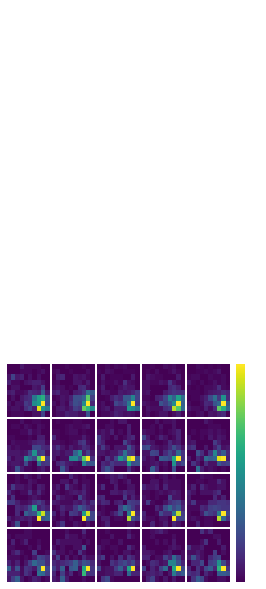

In [124]:
import seaborn as sn
import matplotlib.pyplot as plt
fig,axn = plt.subplots(4,5,figsize=(4,4))
plt.subplots_adjust(wspace=0.05,hspace=0.05)
cbar_ax = fig.add_axes([.92, .125, .03, .755])
idx=0
for i in range(4):
    for t in range(5):
        sn.heatmap(seq_test[0,t,i],
        cmap='viridis',
        ax=axn.flat[idx],
        cbar_kws={'ticks':[]},
        cbar_ax=cbar_ax,
        xticklabels=False, yticklabels=False)
        idx += 1
plt.show()

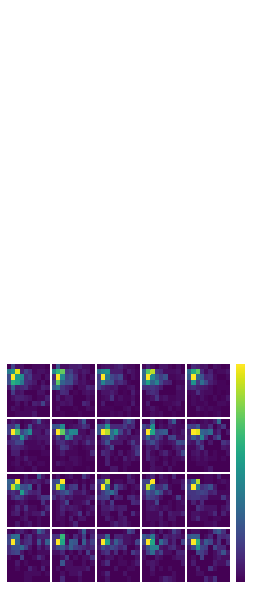

In [125]:
fig,axn = plt.subplots(4,5,figsize=(4,4))
plt.subplots_adjust(wspace=0.05,hspace=0.05)
cbar_ax = fig.add_axes([.92, .125, .03, .755])
idx=0
for i in range(4):
    for t in range(5):
        sn.heatmap(seq_test_rot[0,t,i],
        cmap='viridis',
        ax=axn.flat[idx],
        cbar_kws={'ticks':[]},
        cbar_ax=cbar_ax,
        xticklabels=False, yticklabels=False)
        idx += 1
plt.show()

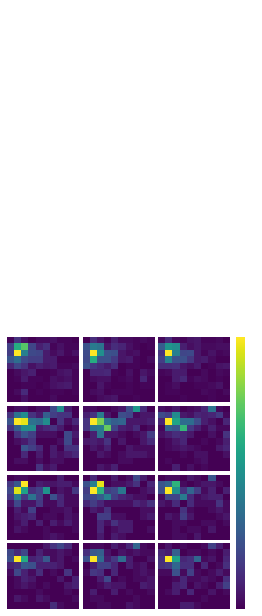

In [126]:
obs = seq_test_rot[:,:5]
gt = seq_test_rot[:,5:]
fig,axn = plt.subplots(4,3,figsize=(4,5))
plt.subplots_adjust(wspace=0.05,hspace=0.05)
cbar_ax = fig.add_axes([.92, .125, .03, .755])
idx=0
for i in range(4):
    for t in range(3):
        sn.heatmap(seq_test_rot[0,5+t,i],
        cmap='viridis',
        ax=axn.flat[idx],
        cbar_kws={'ticks':[]},
        cbar_ax=cbar_ax,
        xticklabels=False, yticklabels=False)
        idx += 1
plt.show()

MAPSED

In [127]:
def predict(seq, model, normalizer):
    output = []
    # print("updating with data [{}/{}]".format(idx+1, len(dataloader_train)))
    #32,13,4,10,10
    seq = torch.tensor(seq).cuda().float()
    x = seq[:, :5]
    y_pred = model(x)[0].data
    output.append(recover_data_tensor(y_pred, max_tensor))
    output = torch.cat(output)
    return output

In [128]:
device = torch.device('cuda')
vae = ConvVAE(input_channels=4).to(device)
vae.load_state_dict(
    torch.load('../../saved_models/SF/VAE-SF.torch'))
m = 5
n = 3

model = MAPSED(vae, latent_shape=(2, 5, 5), m=m, n=n,
               lambda_contrast=10, contrast='L2',lambda_MAE=1).to(device)
model.load_state_dict(torch.load('../../saved_models/SF/mapsed.torch'))
model.training = False
model.eval()
vae.eval()
vae.training = False


# mean_tensor = torch.tensor(seq_train.mean(axis=(0,1,3,4))).cuda().float()
# mean = seq_train.mean(axis=(0,1,3,4))
max = np.array([seq_train[:,:,i].max() for i in range(4)])
max_tensor = torch.tensor(max).cuda().float()
predicts_MAPSED = predict(seq_test_rot, model, max_tensor).cpu()

GRU

In [129]:
from src.baselines.convGRU.ConvGRU import model
convLSTM = model().to(device)
convLSTM.load_state_dict(torch.load(
    '../../saved_models/SF/convLSTM/convLSTM.torch'))
pred_GRU = convLSTM(torch.tensor(seq_test[:,:5]).cuda().float()).data.cpu()

CSAN

In [130]:
from src.baselines.csan.CSAN import CSAN

def encode_seq(x, vae, z_dim, m=15, n=3, bs=32):
    # x dim: 13*32*1*10*10
    z_x = torch.zeros(size=[m, bs, 1, z_dim * 2])
    z_y = torch.zeros(size=[n, bs, 1, z_dim * 2])
    for i in range(m):
        z_temp, mu, logvar = vae.encode(x[i].unsqueeze(1))
        z_temp = torch.cat((mu, logvar), dim=1)
        z_x[i] = z_temp.unsqueeze(1)
    for j in range(m, m + n):
        z_temp, mu, logvar = vae.encode(x[j].unsqueeze(1))
        z_temp = torch.cat((mu, logvar), dim=1)
        z_y[j - m] = z_temp.unsqueeze(1)
    return z_x, z_y


def decode_seq(z_y, vae, m=15, n=3, bs=32, z_dim=6):
    # z_y: 3*32*1*2z_dim
    z_y = z_y.squeeze()
    y = torch.zeros(size=[n, bs, 1, 10, 10])
    for i in range(z_y.shape[0]):
        # First 6 dims is mean
        y[i] = vae.decode(z_y[i][:, 0:z_dim])
    return y.cuda()




def predictC(x, model, vaes, m=5, n=3):
    [vae1,vae2,vae3,vae4] = vaes
    out =[]
    x = torch.tensor(x).transpose(0, 1).cuda().float()
    y = x[-n:, :]
    # zdim: m*bs*1*zdim
    z_x1, _ = encode_seq(x[:, :, 0], vae1, z_dim, m=m, n=n)
    z_x2, _ = encode_seq(x[:, :, 1], vae2, z_dim, m=m, n=n)
    z_x3, _ = encode_seq(x[:, :, 2], vae3, z_dim, m=m, n=n)
    z_x4, _ = encode_seq(x[:, :, 3], vae4, z_dim, m=m, n=n)
    # concat, dim: m*bs*4*zdim
    z_x = torch.cat((z_x1, z_x2, z_x3, z_x4), 2).unsqueeze(2).cuda()
    z_y_pred = model(z_x)
    for i in range(4):
        y_pred = decode_seq(z_y_pred[:, :, :, i, :], vaes[i], m=m, n=n)
        #bs l c w h
        out.append(y_pred.transpose(0,1).squeeze().data)
    out = torch.stack(out, dim=2)
    return out


device = torch.device('cuda')
input_channels = 1
z_dim = 6
bs = 32
epochs = 20
n = 3
m = 5
csan_losses = []
# torch.autograd.set_detect_anomaly(True)
csan = CSAN(input_channels=input_channels, bs=32, m=m, n=n, z_dim=z_dim).to(device)
vaes = []
for i in range(1,5):
    vae = VAE(input_channels=input_channels,
              z_dim=z_dim, bs=bs).to(device)
    path =  '../../saved_models/SF/CSAN/vae{}-ft.torch'.format(i)
    vae.load_state_dict(torch.load(path))
    vaes.append(vae)

csan.load_state_dict(torch.load('../../saved_models/SF/CSAN/csan.torch'))

<All keys matched successfully>

In [131]:
predict_CSAN = predictC(seq_test_rot, csan, vaes)

NN-CCRF

In [132]:
from src.baselines.nn_ccrf.nn_ccrf import NN_CCRF
dim_inputs = 100
rnn_hidden = 25
models_ccrf = [NN_CCRF(dim_inputs, rnn_hidden, rnn_layer=4, num_layer=2).to(torch.device('cuda')) for i in range(4)]
c = 0
for model in models_ccrf:
    model_path = '../../saved_models/SF/NN-CCRF/NN-CCRF-{}.torch'.format(c)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    c += 1
def predict_ccrf(x, models):
    x = torch.tensor(x).cuda().float()
    y_pred = []
    for cat in range(4):
        inputs = x[:, :, cat].reshape((-1, 5, 100))
        y_pred_c = models[cat](inputs).reshape(-1,1,10,10)
        y_pred.append(y_pred_c)
    return torch.stack(y_pred, dim=2).data.cpu()

In [133]:
predict_CCRF =predict_ccrf(seq_test_rot[:,:5], models_ccrf)
predict_CCRF.shape

torch.Size([32, 1, 4, 10, 10])

DuroNet

In [134]:
from src.baselines.duronet.drnet import DuroNet

models_drnet = [DuroNet(d_word_vec=100, n_layers=2, n_head=2, d_k=6, d_v=6,
                      d_model=100, d_inner=6, dropout=0.1, n_position=200,
                      seq_len=5, con_size=3, days=3, kernel='stcn',
                      kernel_size_tcn=3, kernel_size_scn=2).to(torch.device('cuda')) for i in range(4)]

c = 0
for model in models_drnet:
    model_path = '../../saved_models/{}/DuroNet/DuroNet-{}.torch'.format('SF', c)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    c += 1

def predict_drnet(x, models):
    y_pred = []
    x = torch.tensor(x).cuda().float()
    for cat in range(4):
        inputs = x[:, :, cat].reshape((-1, 5, 100))
        y_pred_c = models[cat](inputs).reshape(-1,1,10,10)
        y_pred.append(y_pred_c)
    return torch.stack(y_pred, dim=2).data.cpu()

In [135]:
predict_DRNET =predict_drnet(seq_test_rot[:,:5], models_drnet)

Comparison

In [136]:
# first sample, first frame
OG = seq_test[0,5]
HIST = obs[0,-1]
MAP = predicts_MAPSED.cpu()[0,0]
GRU = pred_GRU.cpu()[0,-1]
CSAN = predict_CSAN.cpu()[0,0]
#new
CCRF = predict_CCRF[0,-1]
DR = predict_DRNET[0,-1]
GT = seq_test_rot[0,5]

<AxesSubplot:>

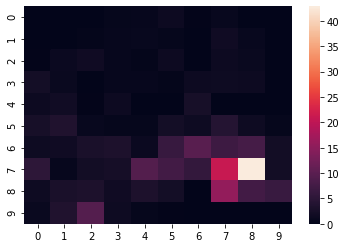

In [137]:
sn.heatmap(pred_GRU[0,0,3])

OBS, PRED

In [138]:
data = np.stack((OG, HIST,GT, GRU, CSAN, CCRF, DR,  MAP),axis=1)
data.shape

(4, 8, 10, 10)

In [139]:
data[0,2].max(),data[1,2].max(),data[2,2].max(),data[3,2].max()

(68.0, 27.0, 37.0, 33.0)

In [140]:
data[0,3].max(),data[1,3].max(),data[2,3].max(),data[3,3].max()

(86.53693389892578, 55.61734390258789, 39.28180694580078, 41.4388313293457)

In [141]:
data[0,4].max(),data[1,4].max(),data[2,4].max(),data[3,4].max()

(87.5544204711914, 60.14439010620117, 45.629093170166016, 38.05785369873047)

In [142]:
data[0,5].max(),data[1,5].max(),data[2,5].max(),data[3,5].max()

(92.57046508789062, 68.70841979980469, 22.830028533935547, 22.886899948120117)

In [143]:

data[0,6].max(),data[1,6].max(),data[2,6].max(),data[3,6].max()

(53.98531723022461, 25.808273315429688, 45.5041618347168, 38.43930435180664)

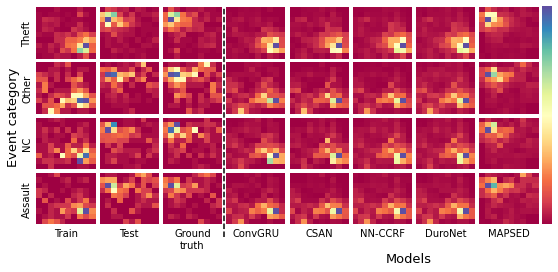

In [144]:
vmaxs=[60,30,30,30]
fig, axn = plt.subplots(4,8,sharex=True,sharey=True, figsize=(9,4))
plt.subplots_adjust(wspace=0.07,hspace=0.07)
cbar_ax = fig.add_axes([.905, .126, .015, .756])
idx = 1
for i in range(4):
    for t in range(8):
        # vmax=vmaxs[i]
        # vmax=vmax,
        if idx == 19:
            sn.heatmap(data[i,t],
                       cmap='Spectral',
                       ax=axn.flat[idx-1], vmax=data[i,t].max(),
                       cbar_kws={'ticks':[]},
                       cbar_ax=cbar_ax,
                       xticklabels=False, yticklabels=False)
        else:
            sn.heatmap(data[i,t],
                       cmap='Spectral',
                       ax=axn.flat[idx-1],vmax=data[i,t].max(),
                       cbar=False,
                       xticklabels=False, yticklabels=False)
        idx += 1


axn.flat[0].set_ylabel('Theft',fontsize=10)
axn.flat[8].set_ylabel('Other', fontsize=10)
axn.flat[16].set_ylabel('NC',fontsize=10)
axn.flat[24].set_ylabel('Assault',fontsize=10)

axn.flat[24].set_xlabel('Train',rotation='horizontal',fontsize=10)
axn.flat[25].set_xlabel('Test',rotation='horizontal',fontsize=10)
axn.flat[26].set_xlabel('Ground\ntruth',rotation='horizontal',fontsize=10)

axn.flat[27].set_xlabel('ConvGRU',rotation='horizontal',fontsize=10)
axn.flat[28].set_xlabel('CSAN',rotation='horizontal',fontsize=10)
axn.flat[29].set_xlabel('NN-CCRF',rotation='horizontal',fontsize=10)
axn.flat[30].set_xlabel('DuroNet',rotation='horizontal',fontsize=10)
axn.flat[31].set_xlabel('MAPSED',rotation='horizontal',fontsize=10)

fig.suptitle('Models',fontsize=13,x=0.70,y=0.03)
fig.align_ylabels(axn[:0])
fig.text(0.09,0.5, 'Event category',rotation='vertical',
         va='center',ha='center',fontsize=13)

fig.add_artist(plt.Line2D([0.415,0.415],[0.08,0.875],
                          color='black',linestyle='--'))

plt.autoscale()


plt.savefig('SF-Rot-output.pdf',bbox_inches='tight')

ERROR


In [145]:
GT = seq_test_rot[0,5]
data_err = np.stack((np.abs(GRU-GT),
                     np.abs(CSAN-GT),
                     np.abs(CCRF-GT),
                     np.abs(DR-GT),
                     np.abs(MAP-GT)),axis=1)
data_err.shape

(4, 5, 10, 10)

In [146]:
np.abs(MAP-GT).max(), np.abs(GRU-GT).max(), np.abs(CSAN-GT).max(), np.abs(DR-GT).max()

(tensor(26.9217, dtype=torch.float64),
 tensor(81.5369, dtype=torch.float64),
 tensor(82.5544, dtype=torch.float64),
 tensor(65.2575, dtype=torch.float64))

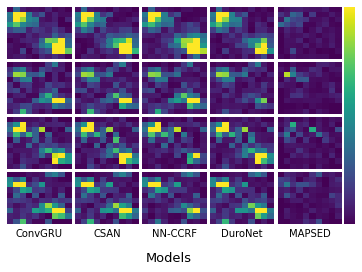

In [147]:
vmaxs=[30,30,20,15]
fig, axn = plt.subplots(4,5,sharex=True,sharey=True, figsize=(6,4))
plt.subplots_adjust(wspace=0.05,hspace=0.05)
cbar_ax = fig.add_axes([.905, .125, .025, .755])
idx = 1
for i in range(4):
    for t in range(0,5):
        vmax=vmaxs[i]
        cmap = 'viridis'
        if idx == 12:
            sn.heatmap(data_err[i,t],
                       cmap=cmap,vmax=vmax,
                       ax=axn.flat[idx-1],
                       cbar_kws={'ticks':[]},
                       cbar_ax=cbar_ax,
                       xticklabels=False, yticklabels=False)
        else:
            sn.heatmap(data_err[i,t],
                       cmap=cmap,vmax=vmax,
                       ax=axn.flat[idx-1],
                       cbar=False,
                       xticklabels=False, yticklabels=False)
        idx += 1


# axn.flat[0].set_ylabel('Theft',fontsize=10)
# axn.flat[3].set_ylabel('Other', fontsize=10)
# axn.flat[6].set_ylabel('NC',fontsize=10)
# axn.flat[9].set_ylabel('Assault',fontsize=10)

axn.flat[15].set_xlabel('ConvGRU',rotation='horizontal',fontsize=10)
axn.flat[16].set_xlabel('CSAN',rotation='horizontal',fontsize=10)
axn.flat[17].set_xlabel('NN-CCRF',rotation='horizontal',fontsize=10)
axn.flat[18].set_xlabel('DuroNet',rotation='horizontal',fontsize=10)
axn.flat[19].set_xlabel('MAPSED',rotation='horizontal',fontsize=10)

fig.suptitle('Models',fontsize=13,x=0.5,y=0.03)
fig.align_ylabels(axn[:0])
# fig.text(0,0.5, 'Event category',rotation='vertical',
#          va='center',ha='center',fontsize=13)

plt.autoscale()

# plt.tight_layout()


plt.savefig('SF-Rot-error.pdf',bbox_inches='tight')

In [148]:
data[0,0].max(),data[1,0].max(),data[2,0].max(),data[3,0].max()

(68.0, 27.0, 37.0, 33.0)

In [149]:
data[0,1].max(),data[1,1].max(),data[2,1].max(),data[3,1].max()

(69.0, 46.0, 45.0, 28.0)

In [150]:
data[0,2].max(),data[1,2].max(),data[2,2].max(),data[3,2].max(),

(68.0, 27.0, 37.0, 33.0)

In [151]:
data[0,3].max(),data[1,3].max(),data[2,3].max(),data[3,3].max()

(86.53693389892578, 55.61734390258789, 39.28180694580078, 41.4388313293457)

In [152]:
data[0,4].max(),data[1,4].max(),data[2,4].max(),data[3,4].max()



(87.5544204711914, 60.14439010620117, 45.629093170166016, 38.05785369873047)